# Iron Bank: sales optimisation using XGBoost

**Scenario:**

"Iron Bank" offers a term deposit product. Since 2 years, Iron Bank has invested massively in reaching out to its portfolio of existing customers (those with already a current account), and had done so through a call center campaign: each customer was called and offered the product.

For doing so, they have been running a process which selects a subset of their customer
portfolio every week, and the list is sent to the call center to be actioned.
So far the campaign had a positive impact, but given the significant cost of the call (~8 Silver Stag) and Iron Bank's strive towards process optimization, the management has decided to investigate how to use Analytics to improve the costs of the process.

Tycho Nestoris, the head of the bank, has asked whether it would be possible to reduce the number of calls by predicting the "wasted calls" (calls to non-converting customers).
Specifically, he asks how many calls can be saved, given that he wants to lose as little
business as possible.

Nestoris adds the following pieces of information:
* Each new contract will generate ~80 Silver Stags profits over its lifetime
* No new contract would have been signed without the call (it's the only advertising
way). Also, we can assume that if a customer didn't buy with the call, he will not buy
at any time.


## Import  libraries, define custom transformers and functions for the data visualisation

* Import libraries to handle the data and build analysis pipelines
* Build custom transformers and define functions for the data visualisation

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as la
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from xgboost import XGBClassifier
from skopt import BayesSearchCV

import itertools
import warnings

from woe_iv import *
from my_helper_funcs import *

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as line
plt.rcParams.update({'font.size': 22})

In [2]:
class num_extractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xnum = X[X.columns[X.dtypes != 'object']]
        return Xnum

class cat_extractor(BaseEstimator, TransformerMixin): 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        Xtxt = X[X.columns[X.dtypes == 'object']]
        return Xtxt

class MultiColumnLabelEncoder(BaseEstimator):
    
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        output = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_income(y_pred, y_test):
    xs = np.linspace(0,1,100)
   
    print('auc score: ', metrics.roc_auc_score(y_test, y_pred))
   
    imp_model = []
    imp_init  = []
   
    for x in xs:
        yt = (y_pred>x)*1
        conf = metrics.confusion_matrix(y_test,  yt)
        imp_model.append(conf[1][1]*(80-8) - conf[0][1]*8)
        imp_init.append((conf[1][1]+conf[1][0])*(80-8) - (conf[0][0]+conf[0][1])*8)
   
    print(max(imp_model), ' ', max(imp_init))
   
    plt.figure(figsize=(10,8))
    plt.plot(xs, imp_model, 'r--', xs, imp_init, 'b--')
    plt.xlabel('threshold')
    plt.ylabel('economic importance')
    plt.grid(True)
    plt.show()

## load data and perform exploratory analysis

data description
* 'age' - cutomer age, [int]
* 'job' - job title, [categorical]
* 'marital' - married/single/divorsed/unknown [categorical]
* 'education' - basic .. university degree [categorical]
* 'default' - yes/no/unknown [categorical]
* 'housing' - yes/no/unknown [categorical]
* 'loan' - yes/no/unknown [categorical]
* 'contact' - cell/phone [categorical]
* 'month' - 1 to 12 [categorical]
* 'day_of_week' - 1 to 7 [categorical]
* 'duration' - call (contact) duration (excluded from analysis, see below)
* 'campaign' - number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 'pdays' - number of days that passed by after the client was last contacted from a previous campaign [numeric]
* 'previous' - number of contacts performed before this campaign and for this client (numeric)
* 'poutcome' - outcome of the previous marketing campaign [categorical]
* 'emp.var.rate' - employment variation rate - quarterly indicator [numeric]
* 'cons.price.idx' - consumer price index - monthly indicator [numeric]
* 'cons.conf.idx' - consumer confidence index - monthly indicator [numeric]
* 'euribor3m' - euribor 3 month rate - daily indicator [numeric]
* 'nr.employed' - number of employees - quarterly indicator [numeric]
* 'y'- target variable: 1/0 -

In [3]:
df = pd.read_csv('bank-additional/bank-additional-full.csv',sep=';')
# df = pd.read_csv('bank-additional/bank-additional.csv',sep=';')
le = LabelEncoder()
df['y'] = le.fit_transform(df['y'])

In [4]:
df.y.value_counts()

0    36548
1     4640
Name: y, dtype: int64

First look at the data

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Some the data visualisation

Data visualisation via histograms/time-trends helps to understand the data, identify outliers/garbage which needs to be removed. Analysis should target to catch the tendencies, not to identify particular outliers.

Histogram below tends to represent comprehensive information about feature: 
* Light blue - total events 
* Dark blue - number of successful events 
* Red circles - percentage of successful events and its confidence interval, per bin

Assuming, that the number of events in histogram bins are following Poisson distribution, the error (1 sigma confidence) per bin would be $\sqrt{n}$. Now, for the ratio of two histogram, propagated Poisson error can be calculated as:

<h3 align="center">$\Delta (\frac{n_1}{n_2}) = \frac{n_2 \sqrt{ n_1} + n_1 \sqrt{n_2}}{{n_2}^2} $</h3> 




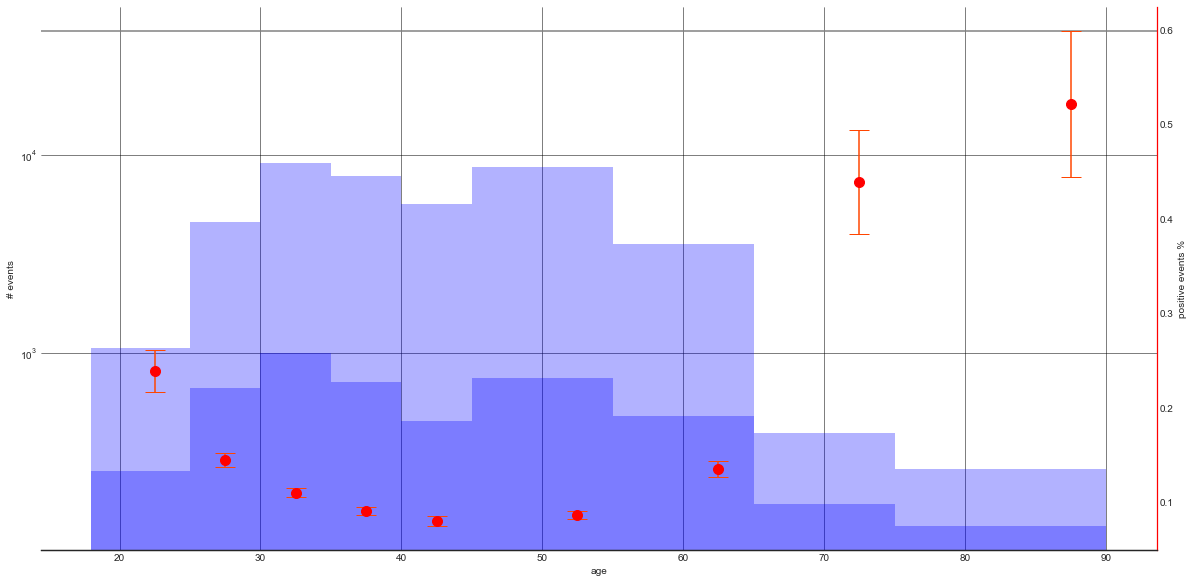

In [6]:
hist_maker(df['age'], df[df.y==1]['age'], 'age',  
           [18, 25, 30, 35, 40, 45, 55, 65, 75, 90])

### High cardinality of the categorical features

This can become problem for any analysis using categorical features. Should try to reduce it based on domain knowledge and merge some basic education levels. As we do it for 'education', merging its basic levels

Also, there is only one entry for 'illiterate', corresponding row can be dropped.


In [7]:
df.education.value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [8]:
df['education'] = np.where(df['education'] =='basic.9y', 'basic', df['education'])
df['education'] = np.where(df['education'] =='basic.6y', 'basic', df['education'])
df['education'] = np.where(df['education'] =='basic.4y', 'basic', df['education'])
df = df.drop(df[df.education == 'illiterate'].index)

In [9]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Variable importance: Information Value 

Lets estimate importance of the features using Information Value (IV), that can help us to quantify predictive power of the features to explain the target variable. In particular, its a common practice to categorize features using IV as following:
* Weak predictive Power [0.02 to 0.1]
* Medium predictive Power [0.1 to 0.3]
* Strong predictive Power [0.3 to 0.5]
* Suspicious Predictive Power [0.5 to Inf.]

N.B. using external code for IV and WoE calculations (file: filename.py)

Features categorisation via Information Value: 
* Grey: weak predictors
* Yellow: medium predictive power
* Green: strong predictive power
* Red area: ‘Too good to be true’ - duration and poutcome.


In [10]:
from woe_iv import *
fiv, iv = data_vars(df, df.y)

/Users/arabidze/Documents/JUPYTER/Allianz_tosend/Allianz/woe_iv.py:94: RuntimeWarning: divide by zero encountered in log
  d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
/Users/arabidze/Documents/JUPYTER/Allianz_tosend/Allianz/woe_iv.py:95: RuntimeWarning: divide by zero encountered in log
  d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)


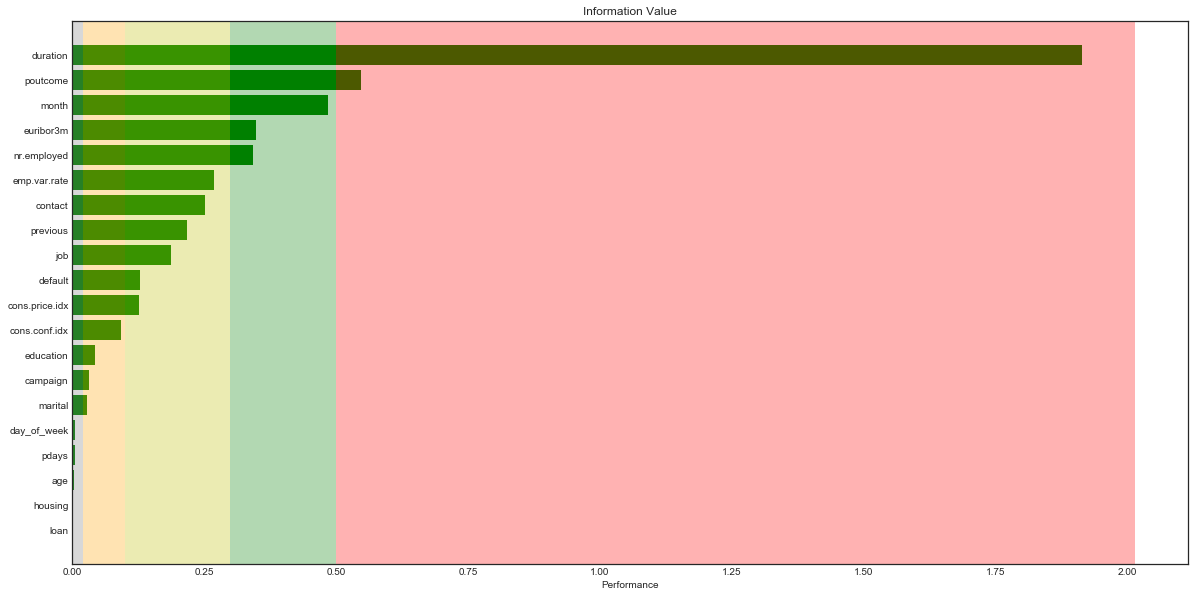

In [11]:
plot_iv(iv.sort_values('IV', ascending=False), name='IV')

Information Value can be useful to identify so called information leakage, or the forward looking bias in your analysis. For example, it iss a *forward looking bias*, when feature reflects conditions from times after the event occurred and hense may have much stronger correlation with the outcome event.

Of course, we can not know the phone call duration prior to the call, at the moment when we need to make prediction, hence can not be used to predict the ‘unknown’. Intuitively, longer the call, higher are chances that client agreed and the contract agreement happened.

Poutcome (outcome of the previous marketing campaign [categorical]), as well shows high IV and indicates strong correlation between outcomes of the previous and current campaigns, which might be naturally expected if there is a strong like/dislike of the product.

Indeed, from the histogram below, we can clearly see that the positive rate is the highest $\sim65%$ in the bin corresponding "previous success", while othe bins are less than $\sim20%$. This could indicate, that the campaign is the best successful with the previous or existing customers (no churn, i.e. strong product attachement), but fails to attract new customers. 

To exclude or include 'Poutcome' feature is more for the judgment call or "up to the bussiness to decide". With this fearure included, we can not conclude about model performance with the new customers. This is strong limitation, as for the model as to it power to generalise.

With this said, next iteration: try to build different models for customers who already purchased or not the banks product.

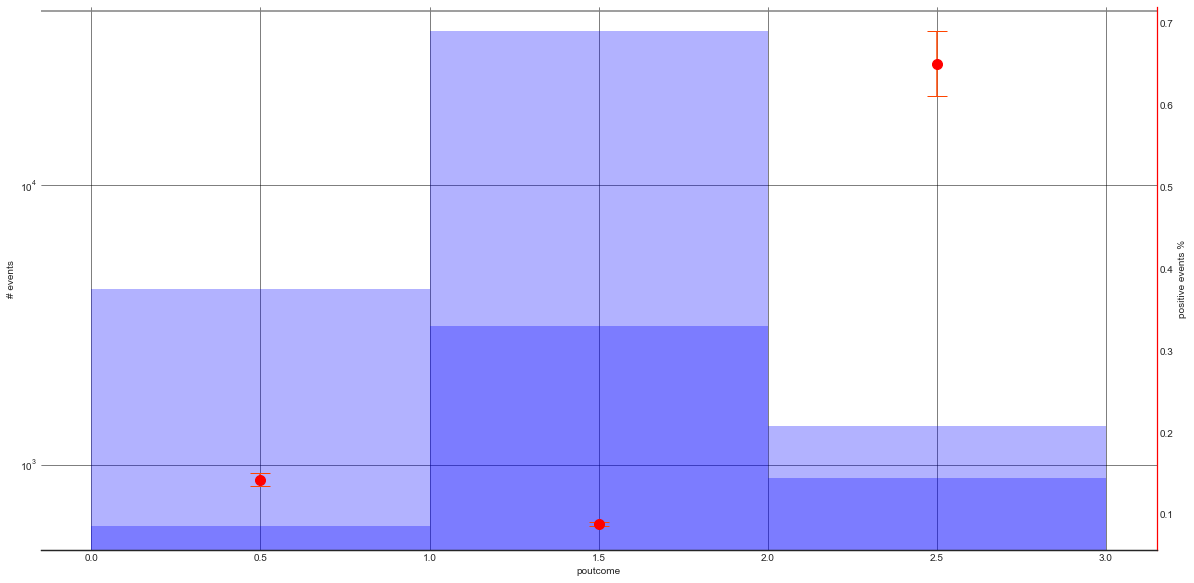

In [12]:
df['poutcome_tmp'] = le.fit_transform(df['poutcome'])
hist_maker(df['poutcome_tmp'], df[df.y==1]['poutcome_tmp'], 'poutcome',  
           [0,1,2,3])
df.drop('poutcome_tmp', axis=1, inplace=True)

** Drop 'duration': **

In [13]:
df.drop('duration', axis=1, inplace=True)
# df.drop('poutcome', axis=1, inplace=True)

In [ ]:
# fiv[['VAR_NAME', 'WOE', 'IV']]

### ** Investigating feature-to-feature correlation **


Table below describes Pearson correlation between all the features. 
High correlation amongst the features, i.e. feature multicollinearity can introduce undesirable complications or even instabilities in some modelling. 

<u> Tree based methods </u>: more robust to the multicollinearity problem, as long as it concerns the prediction correctness. However, it can introduce ambiguity in feature selection and hence to the feature importance estimation. Collinear features can be selected equally likely at each split and their individual power (i.e. number of times the feature was used to split) will vanish. 

<u> Ordinary Least Squares regression (OLS) </u>: less robust to the multicollinearity problem. If features are linearly dependent (some columns of X), then the rank of matrix X is less than p+1 (where p is number of the features). So, the matrix X is singular and inverse of $X^T X$ matrix doesn’t exists, which is required in the closed form equation:

<h3 align="center">$\beta = (X^T X)^{-1}X^TY$</h3> 

Even if we could overcome the singularity (via … ), still the estimates  expected to be unstable and can be estimated using Variance Infiltration Factor. It measures how much variance of feature $x_i$ can be explained by the other features.

Highly unstable estimates means that if there is a small change in X, produces very large changes in the solution: Stability of an estimate can be measured using condition number:

<h3 align="center">$cond. number = \frac{\mu_{max}}{\mu_{min}} $</h3> 

We can compare the matrix stabilities with included and excluded highly correlated (more than 65%) features. Difference is significant:
* Cond. Number (w/ correlated features): **10.2**
* Cond. Number (w/o correlated features): **1.6**


In [14]:
corr = df.drop('y',axis=1).corr(method='pearson').abs()
corr = corr.round(2)
corr.style.background_gradient().set_precision(2)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1,0,0.03,0.02,0,0,0.13,0.01,0.02
campaign,0,1,0.05,0.08,0.15,0.13,0.01,0.14,0.14
pdays,0.03,0.05,1,0.59,0.27,0.08,0.09,0.3,0.37
previous,0.02,0.08,0.59,1,0.42,0.2,0.05,0.45,0.5
emp.var.rate,0,0.15,0.27,0.42,1,0.78,0.2,0.97,0.91
cons.price.idx,0,0.13,0.08,0.2,0.78,1,0.06,0.69,0.52
cons.conf.idx,0.13,0.01,0.09,0.05,0.2,0.06,1,0.28,0.1
euribor3m,0.01,0.14,0.3,0.45,0.97,0.69,0.28,1,0.95
nr.employed,0.02,0.14,0.37,0.5,0.91,0.52,0.1,0.95,1


In [15]:
la.eigvals(corr.values)[0]/la.eigvals(corr.values)[-1]

8.776916617477557

In [ ]:
dropables = find_correlation(df.drop('y',axis=1).corr(),threshold=0.85)

for c in df.columns:
    if c in dropables:
        df.drop(c, axis=1, inplace=True)

In [ ]:
corr = df.drop('y',axis=1).corr(method='pearson').abs()
corr = corr.round(2)

la.eigvals(corr.values)[0]/la.eigvals(corr.values)[-1]

## Analysis Pipeline 


* Stratified train-test data split on 80/20%. Where, stratification is to ensure the same good/bad ratio of the events after the each split. That is very important for the highly unbalanced datasets:
> * Train-dataset (80%) - use for hyper parameters tuning, with 3 fold cross-validation 
> * Test-dataset (20%) - make predictions

**Machine Learning model selection**

Model selection - choise of the algorithm for the data analysis, is strongly defined by the data structure/type, as well as available resources. In our case, the data is the mixture of categorical and numeric features, each possibly with different origine and source. Considering known experience, following Machine Learning models are the most recommended for the given data:

* Boosted decision tree (using XGBoost), hyper parameters to tune:
> * Learning Rate - level of influence the consecutive learner 
> * max depth - of each tree
> * gamma - 
> * colsample - 

* Logistic regression 
> * todo


**Analysis pipeline:**

Pipelines are useful - more task standartisation, less trouble to rearrange the code and etc.

> * categorical features
>> * Decision tree models - apply label encoding, as for trees it is easier to work with the label encoded features (custom transformer implemented)
>> * Logistic regression - apply one-hot-encoding
> * numerical features - to standartize

Using Log Loss function to measure performance of the classifier, during Bayesian Cross Validation search.

Final model selection (decision trees vs logistic regression) should reflect the economics importance of the model.


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df.y, 
                                                    stratify=df.y,
                                                    test_size=0.20, random_state=42)


ratio = (y_train == 0).sum()/y_train.sum()
print('ratio: ', ratio)

xgb_params = [{
    #
    'xg__learning_rate':[0.01,0.8],
    'xg__max_depth':[3,6],
    'xg__gamma':[2,10],
    'xg__colsample_bytree':[0.2,1],
    'xg__colsample_bylevel':[0.2,1],
    'xg__reg_lambda':[0.01,1],
    'xg__scale_pos_weight': [ratio] 
    }]

pipe = Pipeline([
    ('by_features', FeatureUnion([
        ('num_pipeline', Pipeline([
            ('num_extractor', num_extractor()), 
            ('standard', StandardScaler())
        ])),
        ('cat_pipeline', Pipeline([
            ('cat_extractor', cat_extractor()), 
            ('cat_labeling',  MultiColumnLabelEncoder())
        ]))
    ])),
    ('xg', XGBClassifier()) 
])

ratio:  7.880021569156106


In [17]:
grid = BayesSearchCV(pipe, xgb_params, cv=3, verbose=0, scoring='log_loss')

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    grid.fit(X_train, y_train) 

In [18]:
grid.best_params_

{'xg__colsample_bylevel': 1.0,
 'xg__colsample_bytree': 0.8509322382775026,
 'xg__gamma': 2,
 'xg__learning_rate': 0.38686981738280624,
 'xg__max_depth': 6,
 'xg__reg_lambda': 1.0,
 'xg__scale_pos_weight': 7.880021569156106}

No handles with labels found to put in legend.


0.7770782224903223
1453
1453


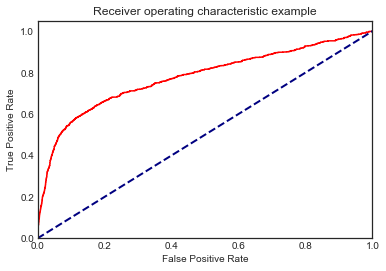

In [19]:
plot_roc(roc_curve(y_test, grid.predict_proba(X_test)[:,1]))

** Confusion Matrix **

* True Positive: 448 
* True Negative: 479
* False Positive: 832
* False Negative: 6475

Confusion matrix, without normalization


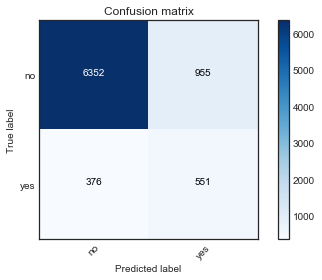

In [22]:
predict_proba = grid.predict_proba(X_test)
plot_confusion_matrix(metrics.confusion_matrix(y_test, (predict_proba[:,1]>0.5)*1), 
                      classes=['no','yes'], title='Confusion matrix')

** Economics importance **

We need to find optimal threshold on probability, which can maximize the Economics importance for the given costs of campaign. Plot below shows Economics importance (EI) as a function of ptobability threshold (red line), and the base line (BL) or the initial income of the bank (blue line).

If the cost of contact is 8 and each contract can generate 80, the EI and BL quantities can be calculated as following:

$EI = TP*(80-8) - FP*8$ <br>
$BL = (TP+TN)(80-8) - (FN+FP)*8$

To be noted: 
* Its a bit exreame case and easy to optimise with the given prices 80 and 8
* Predictive models degradate in time.

auc score:  0.7770782224903223
32584   8288


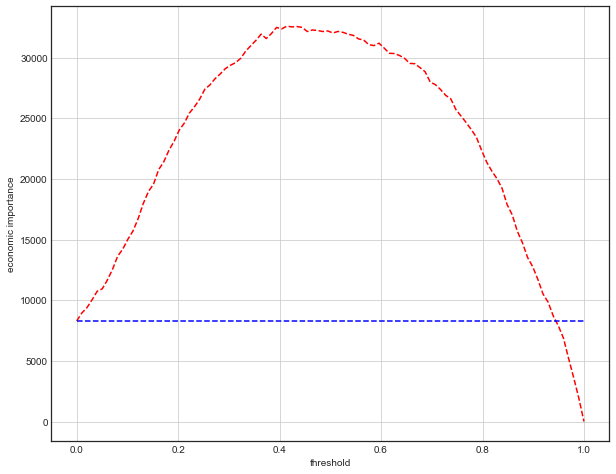

In [25]:
# predict_proba = grid.predict_proba(X_test)
plot_income((predict_proba[:,1]), y_test)

### Investigate probabilities

(array([5557.,  745.,  357.,  203.,  158.,  123.,   81.,   79.,   70.,
          89.,   70.,   77.,   80.,   72.,   88.,  102.,  148.,  135.,
           0.,    0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 1 Patch objects>)

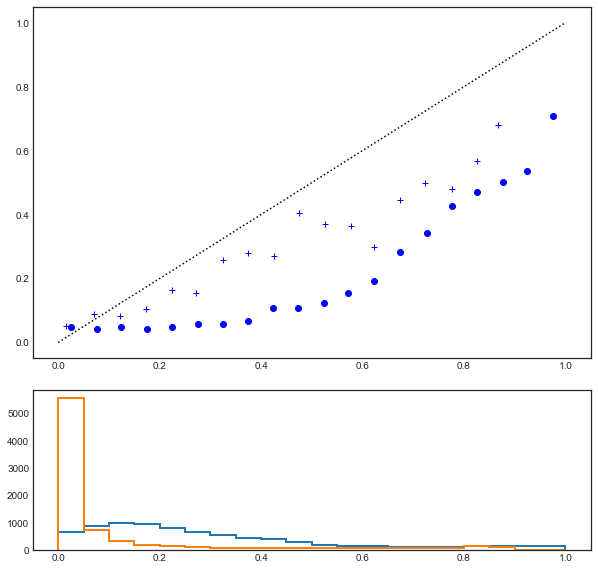

In [27]:

prob_pos = predict_proba[:,1]


calib_grid = CalibratedClassifierCV(base_estimator=\
                                    grid.best_estimator_.named_steps['xg'],
                                    method='sigmoid',
#                                     method='isotonic',
                                    cv='prefit')


imputer = grid.best_estimator_.named_steps['by_features']
calib_grid.fit(imputer.fit_transform(X_train), y_train)

prob_pos_calib = calib_grid.predict_proba(imputer.fit_transform(X_test))[:,1]


plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=20)

fraction_of_positives_calib, mean_predicted_value_calib = \
        calibration_curve(y_test, prob_pos_calib, n_bins=20)

ax1.plot(mean_predicted_value, fraction_of_positives, 'bo', label='y')
ax1.plot(mean_predicted_value_calib, fraction_of_positives_calib, 'b+', label='y')

ax2.hist(prob_pos, range=(0, 1), bins=20, label='name', histtype="step", lw=2)
ax2.hist(prob_pos_calib, range=(0, 1), bins=20, label='name', histtype="step", lw=2)

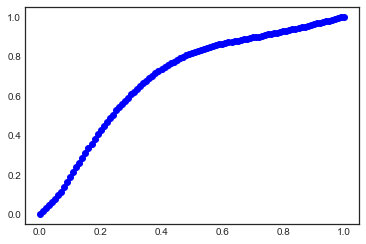

In [29]:
dd = [sum(prob_pos < (0.01*i))/len(prob_pos) 
      for i in range(0,101)]

plt.plot([i/100 for i in range(0,101)], dd, 'bo') 
plt.show()
# plt.hist(dd)
# plt.show()

In [ ]:
dd = [sum(prob_pos_calib < (0.01*i))/len(prob_pos_calib) 
      for i in range(0,101)]

plt.plot([i/100 for i in range(0,101)], dd, 'bo') 
plt.show()

In [ ]:
# clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
X_train